In [1]:
import matplotlib.pyplot as plt
import numpy as np
import platform
import os
import imblearn
from sklearn.utils import class_weight

%matplotlib inline
%load_ext autoreload
%aimport utils
%autoreload 1

Using TensorFlow backend.


In [2]:
### CACHE FILENAMES ###

train_normal_cache = "training_normal.pickle"
train_pneumonia_cache = "training_pneumonia.pickle"
val_normal_cache = "validation_normal.pickle"
val_pneumonia_cache = "validation_pneumonia.pickle"
test_normal_cache = "testing_normal.pickle"
test_pneumonia_cache = "testing_pneumonia.pickle"

### DATA SETTINGS ###

pdiv = "/" if platform.system() == "Windows" else "\\"

path_train_normal = ".{}chest_xray{}train{}NORMAL{}".format(pdiv, pdiv, pdiv, pdiv)
path_train_pneumonia = ".{}chest_xray{}train{}PNEUMONIA{}".format(pdiv, pdiv, pdiv, pdiv)
path_val_normal = ".{}chest_xray{}val{}NORMAL{}".format(pdiv, pdiv, pdiv, pdiv)
path_val_pneumonia = ".{}chest_xray{}val{}PNEUMONIA{}".format(pdiv, pdiv, pdiv, pdiv)
path_test_normal = ".{}chest_xray{}test{}NORMAL{}".format(pdiv, pdiv, pdiv, pdiv)
path_test_pneumonia = ".{}chest_xray{}test{}PNEUMONIA{}".format(pdiv, pdiv, pdiv, pdiv)

### LABELS ###

normal_label = 0
pneumonia_label = 1
labels = sorted([normal_label, pneumonia_label])

### IMAGE SETTINGS ###

dimension = (64, 64, 3)
resize_dim = dimension[:2]

In [3]:
### LOAD TRAINING DATA AND LABELS ###

data_train_normal, label_train_normal = utils.load_data(path_train_normal, train_normal_cache, normal_label)
data_train_pneumonia, label_train_pneumonia = utils.load_data(path_train_pneumonia, train_pneumonia_cache, pneumonia_label)

# Caching, disabled for now
# utils.cache(data_train_normal, train_normal_cache)
# utils.cache(data_train_pneumonia, train_pneumonia_cache)

# Combine training images and labels
data_train = np.concatenate((data_train_normal, data_train_pneumonia), axis=0)
label_train = np.asarray(label_train_normal + label_train_pneumonia)

# Shuffle
rand_order = np.random.permutation(data_train.shape[0])
data_train = data_train[rand_order]
label_train = label_train[rand_order]

del data_train_normal
del data_train_pneumonia

Cache not found, loading images..
Cache not found, loading images..


In [4]:
### IMAGE PROCESSING ###

# Image cropping
data_train = utils.images_crop_from_centre(data_train, percentage=0.9)

# Image resizing
data_train = utils.images_resize(data_train, resize_dim) 

# Image normalisation
data_train = utils.images_normalize(data_train)

In [5]:
### HANDLE IMBALANCED DATA ###
from collections import Counter
from imblearn.over_sampling import SMOTE, RandomOverSampler, KMeansSMOTE, BorderlineSMOTE

# Scatter plot by class label
# for label, _ in counter.items():
#     row_ix = np.where(label_train == label)[0]
#     plt.scatter(data_train[row_ix, 0], data_train[row_ix, 1], label=str(label))
# plt.legend()
# plt.show()

# Transform the dataset
# oversample = SMOTE(sampling_strategy='auto', k_neighbors=8, random_state=100)
# oversample = KMeansSMOTE(sampling_strategy='auto', k_neighbors=8, random_state=100)
# oversample = RandomOverSampler(random_state=42)
oversample = BorderlineSMOTE(random_state=100)
data_train, label_train = oversample.fit_resample(data_train.reshape(data_train.shape[0], -1), label_train)
data_train = data_train.reshape(data_train.shape[0], dimension[0], dimension[1], dimension[2])

# Scatter plot by class label
# for label, _ in counter.items():
#     row_ix = np.where(label_train_resample == label)[0]
#     plt.scatter(data_train_resample[row_ix, 0], data_train_resample[row_ix, 1], label=str(label))
# plt.legend()
# plt.show()

# Shuffle
rand_order = np.random.permutation(data_train.shape[0])
data_train = data_train[rand_order]
label_train = label_train[rand_order]

In [6]:
class_weights = class_weight.compute_class_weight('balanced', np.asarray(labels), label_train)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 1.0, 1: 1.0}


In [10]:
### MODEL PARAMETERS ###
loss_func = "mean_squared_error"
epochs_num = 30
num_of_trainable_layers = 13
model_name = "vgg19_smote"
checkpoint_name = "_best_overall"
intermediary_name = model_name + checkpoint_name
ext = ".hdf5"

In [11]:
### MODEL CREATION ###
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201
from keras.applications.resnet_v2 import ResNet50V2, ResNet101V2, ResNet152V2
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.layers import Dense, GlobalMaxPooling2D, Conv2D, Dropout, GaussianNoise
from keras.models import Model, load_model
from keras.utils import print_summary
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Set model
# base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=dimension, pooling='max')
# base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=dimension, pooling='max')
# base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=dimension, pooling='max')
# base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=dimension, pooling='max')
# base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=dimension, pooling='max')
# base_model = ResNet101V2(weights='imagenet', include_top=False, input_shape=dimension, pooling='max')
# base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=dimension, pooling='max')
# base_model = VGG16(weights='imagenet', include_top=False, input_shape=dimension, pooling='max')
base_model = VGG19(weights='imagenet', include_top=False, input_shape=dimension, pooling='max')

model = base_model.output
model = GaussianNoise(0.4)(model)
model = Dropout(0.5)(model)
model = Dense(32, activation='relu')(model)
model = Dropout(0.5)(model)
model = Dense(16, activation='relu')(model)
model = Dropout(0.3)(model)
preds = Dense(units=1, activation='sigmoid')(model)
model = Model(inputs=base_model.input, outputs=preds)

# Set trainable layers
for layer in model.layers[:-num_of_trainable_layers]:
    layer.trainable = False
for layer in model.layers[-num_of_trainable_layers:]:
    layer.trainable = True

# Callbacks
es_val_loss = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
es_val_acc = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=4)
checkpointer = ModelCheckpoint(intermediary_name + ext, verbose=1, save_best_only=True)
callbacks_list = [es_val_loss, es_val_acc, checkpointer]

# Define optimiser, loss function, and metrics to track
opt = SGD(lr=0.01)
model.compile(optimizer=opt, loss=loss_func, metrics=['accuracy'])

print("Total number of layers is {}".format(len(model.layers)))
print_summary(model)

Total number of layers is 30
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (

In [12]:
# Model training
history = model.fit(data_train, label_train, epochs=epochs_num, callbacks=callbacks_list, validation_split=0.1, verbose=1, class_weight=class_weights)

Train on 6975 samples, validate on 775 samples
Epoch 1/30
6975/6975 [==============================] - 216s 31ms/step - loss: 0.1795 - accuracy: 0.7267 - val_loss: 0.0640 - val_accuracy: 0.9174

Epoch 00001: val_loss improved from inf to 0.06405, saving model to vgg19_smote_best_overall.hdf5
Epoch 2/30
6975/6975 [==============================] - 228s 33ms/step - loss: 0.1046 - accuracy: 0.8602 - val_loss: 0.0432 - val_accuracy: 0.9394

Epoch 00002: val_loss improved from 0.06405 to 0.04324, saving model to vgg19_smote_best_overall.hdf5
Epoch 3/30
6975/6975 [==============================] - 209s 30ms/step - loss: 0.0766 - accuracy: 0.8982 - val_loss: 0.0463 - val_accuracy: 0.9432

Epoch 00003: val_loss did not improve from 0.04324
Epoch 4/30
6975/6975 [==============================] - 195s 28ms/step - loss: 0.0653 - accuracy: 0.9161 - val_loss: 0.0312 - val_accuracy: 0.9652

Epoch 00004: val_loss improved from 0.04324 to 0.03116, saving model to vgg19_smote_best_overall.hdf5
Epoch 5/

In [13]:
del data_train

In [14]:
### LOAD VALIDATION DATA AND LABELS ###

data_val_normal, label_val_normal = utils.load_data(path_val_normal, val_normal_cache, normal_label)
data_val_pneumonia, label_val_pneumonia = utils.load_data(path_val_pneumonia, val_pneumonia_cache, pneumonia_label)

# Caching, disabled for now
# utils.cache(data_val_normal, val_normal_cache)
# utils.cache(data_val_pneumonia, val_pneumonia_cache)

# Combine validation images and labels
data_val = np.concatenate((data_val_normal, data_val_pneumonia), axis=0)
label_val = np.asarray(label_val_normal + label_val_pneumonia)

# Shuffle
rand_order = np.random.permutation(data_val.shape[0])
data_val = data_val[rand_order]
label_val = label_val[rand_order]

del data_val_normal
del data_val_pneumonia

Cache not found, loading images..
Cache not found, loading images..


In [15]:
### LOAD TESTING DATA AND LABELS ###

data_test_normal, label_test_normal = utils.load_data(path_test_normal, test_normal_cache, normal_label)
data_test_pneumonia, label_test_pneumonia = utils.load_data(path_test_pneumonia, test_pneumonia_cache, pneumonia_label)

# Caching, disabled for now
# utils.cache(data_test_normal, test_normal_cache)
# utils.cache(data_test_pneumonia, test_pneumonia_cache)

# Combine training images and labels
data_test = np.concatenate((data_test_normal, data_test_pneumonia), axis=0)
label_test = np.asarray(label_test_normal + label_test_pneumonia)

# Shuffle
rand_order = np.random.permutation(data_test.shape[0])
data_test = data_test[rand_order]
label_test = label_test[rand_order]

del data_test_normal
del data_test_pneumonia

Cache not found, loading images..
Cache not found, loading images..


In [16]:
# Image processing for both
data_val = utils.images_crop_from_centre(data_val, percentage=0.9)
data_val = utils.images_resize(data_val, resize_dim) 
data_val = utils.images_normalize(data_val)

data_test = utils.images_crop_from_centre(data_test, percentage=0.9)
data_test = utils.images_resize(data_test, resize_dim) 
data_test = utils.images_normalize(data_test)

In [17]:
# Delete existing model
del model

# Load best version of model
model = load_model(intermediary_name + ext)

In [18]:
# Validation and testing
val_loss, val_accuracy = model.evaluate(data_val, label_val)
test_loss, test_accuracy = model.evaluate(data_test, label_test)

print(val_loss, val_accuracy)
print(test_loss, test_accuracy)

624/624 [==============================] - 9s 15ms/step
0.06700697541236877 0.9375
0.15467617890009513 0.8253205418586731


In [19]:
del data_val
del data_test

In [20]:
# Save the model for usage
model.save(model_name + "_" + str(int(test_accuracy * 100)) + ext)

# Delete intermediary model
if os.path.exists(intermediary_name + ext):
    os.remove(intermediary_name + ext)

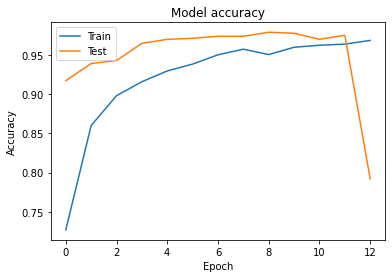

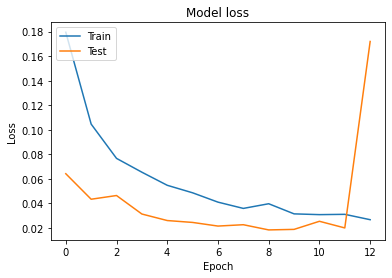

In [21]:
### VISUALISATION ###

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()